## Importing libraries

This MLP network is created from scratch using only the numpy library. It focuses on introductory algorithms and techniques, making numpy the sole necessary library. This minimalist approach highlights the fundamental concepts of neural networks while relying on numpy's powerful numerical computations for essential operations.


In [16]:
import sys
sys.path.insert(0, '../helper')
import mnist_loader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Activation Functions Class

In [17]:
class Activation:
  """
    - Activation functions.
    - |And their derivatives
  """

  @classmethod
  def sigmoid(cls, vec):
    """
      Sigmoid activation function.
    """
    return 1.0 / (1.0 + np.exp(-vec))

  @classmethod
  def sigmoid_drv(cls, vec):
    """
      Sigmoid function derivative.
    """
    return cls.sigmoid(vec) * (1 - cls.sigmoid(vec))

  @classmethod
  def step(cls, vec):
    """
      Binary Step activation function.
    """
    return np.where(vec > 0, 1, 0)

## Loss Function Class

In [18]:
class Cost:
  """
    - Cost functions.
  """

  @classmethod
  def cost_derivative(cls, output_activations, y):
    """
      - Return the vector of partial derivatives partial C(x).
      - Partial a for the output activations.
    """
    return (output_activations-y)

## Network Object

In [19]:
class Network:
  """
    - A Feed Foward Neural Network.
    - Uses Stochastic Gradient Descent learning algorithm.
    - Gradients are being caculated using back propagation.
    - Misses some optimizations and omits some desirable features.
  """
  def __init__(self, sizes):
    self.num_layers = len(sizes)
    self.sizes = sizes
    self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
    self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

  def feed_foward(self, a):
    """
      Calculates the final result of a input going through the NN.
    """
    for b, w in zip(self.biases, self.weights):
      a = Activation.sigmoid(np.dot(w, a) + b)
    return a

  def update_mini_batch(self,  mini_batch, eta):
    """
      - Updates the network's weights and biases by applying gradient descent using backpropagation to a single mini batch.
      - The "mini_batch" is a list of tuples "(x, y)".
      - "eta is the learning rate.
    """

    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]

    # Nabla lists are lists of numpy arrays, in the same way as self.weights and self.biases
    # They store, by adding, all the changes in the weights calculated by the back propagation algorithm
    for x, y in mini_batch:
      delta_nabla_b, delta_nabla_w = self.back_propagation(x, y)

      nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
      nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

    # Recalculate weights for a mini-batch run
    self.weights = [w - (eta/len(mini_batch)) * nw for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b - (eta/len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]

  def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
    """
      - Utilizes mini-batch stochastic gradient descent for training the neural network.
      - The "training_data" consists of tuples "(x, y)" representing input and desired output.
      - Other parameters are self-explanatory.
      - If "test_data" is provided, the network evaluates against it after each epoch, allowing for progress tracking but at a slower pace.
    """

    if test_data:
      test_data = list(test_data)
      n_test = len(test_data)

    training_data = list(training_data)
    n = len(training_data)

    for j in range(epochs):
      random.shuffle(training_data)
      mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]

      for mini_batch in mini_batches:
        self.update_mini_batch(mini_batch, eta)

      if test_data :
        print(f"Epoch {j}: {self.evaluate(test_data)} / {n_test}")

      else:
        print(f"Epoch {j}: complete")


  def back_propagation(self, x, y):
    """
      - Returns a tuple "(nabla_b, nabla_w)" representing the gradient for the chosen Cost Function C(x).
      - "nabla_b" & "nabla_w" are layer-by-layer lists of numpy arrays.
      - Similar to "self.biases" and "self.weights".
      - How much is the adjustment.
    """

    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]

    # Feed-foward phase

    activation = x
    activations = [x] # Stores activations layer by layer
    zs = [] # Stores all the z vectores, layer-by-layer

    for b, w in zip(self.biases, self.weights):
      z = np.dot(w, activation) + b
      zs.append(z)
      activation = Activation.sigmoid(z)
      activations.append(activation)

    # Backward pass -> delta rule
    delta = Cost.cost_derivative(activations[-1], y) * Activation.sigmoid_drv(zs[-1])

    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    # In the following loop we want to iterate from the last to the first layer, excluding the output and the input layers
    # We are taking advantage that python can use negative indices

    for l in range(2, self.num_layers):
      z = zs[-l]
      sig_dv = Activation.sigmoid_drv(z)
      delta = np.dot(self.weights[-l+1].transpose(), delta) * sig_dv
      nabla_b[-l] = delta
      nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())

    return (nabla_b, nabla_w)


  def evaluate(self, test_data):
    """
      - Evaluates the number of correct predictions of the NN.
      - The output is chosen by the "winner takes all" rule, where the highest number on the output vector is the prediction
    """
    test_results = [(np.argmax(self.feed_foward(x)), y) for (x, y) in test_data]

    return sum (int(x == y) for (x, y) in test_results)


  def debug(self):
    """
      - Write any code for debbuging.
    """

## Training

In this section we're going to train this simple Mlp using the mnist dataset in the ".pkl" file, using its default data division.

In [20]:
net = Network([784, 30, 10])
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

#epochs, mini_batch_size, eta,
net.SGD(training_data, 30, 10, 4.0, test_data=test_data)

Epoch 0: 9147 / 10000
Epoch 1: 9298 / 10000
Epoch 2: 9346 / 10000
Epoch 3: 9399 / 10000
Epoch 4: 9435 / 10000
Epoch 5: 9438 / 10000
Epoch 6: 9430 / 10000
Epoch 7: 9428 / 10000
Epoch 8: 9477 / 10000
Epoch 9: 9450 / 10000
Epoch 10: 9478 / 10000
Epoch 11: 9514 / 10000
Epoch 12: 9486 / 10000
Epoch 13: 9505 / 10000
Epoch 14: 9482 / 10000
Epoch 15: 9500 / 10000
Epoch 16: 9515 / 10000
Epoch 17: 9515 / 10000
Epoch 18: 9537 / 10000
Epoch 19: 9546 / 10000
Epoch 20: 9522 / 10000
Epoch 21: 9525 / 10000
Epoch 22: 9508 / 10000
Epoch 23: 9529 / 10000
Epoch 24: 9532 / 10000
Epoch 25: 9539 / 10000
Epoch 26: 9529 / 10000
Epoch 27: 9545 / 10000
Epoch 28: 9539 / 10000
Epoch 29: 9528 / 10000


## Tuning

## Sigmoid X Step

The step function is a simple neuron-like function that fires an electric impulse when the input value reaches a threshold. It's a natural representation of how neurons work. However, it has limitations because it is a non-derivative function. This means we cannot use techniques like Gradient Descent to adjust the weights of the neural network.

To overcome this limitation, we can use the sigmoid function. Unlike the step function, the sigmoid function can be differentiated, allowing us to calculate weight adjustments using techniques like Gradient Descent.

These concepts provide an introductory understanding of activation functions in neural networks.

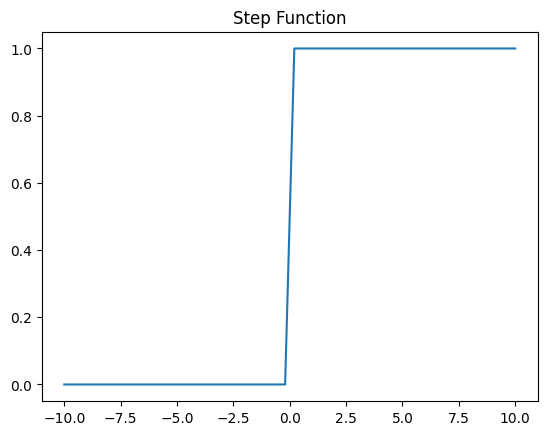

In [18]:
x = np.linspace(-10, 10)
z = Activation.step(x)

plt.plot(x, z)
plt.title("Step Function")
plt.show()

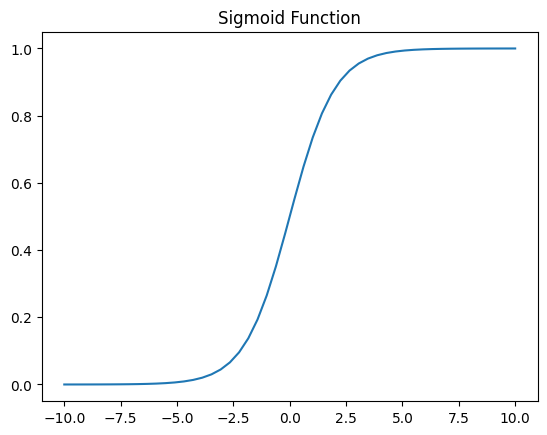

In [19]:
x = np.linspace(-10, 10)
y = Activation.sigmoid(x)

plt.plot(x, y)
plt.title("Sigmoid Function")
plt.show()